In [393]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

import ffn

%matplotlib inline

# Hack to ensure the notebook can load local modules by appending the parent directory to the system path
# Ensure a '.env' file is in the workspace root so location can be detected
from dotenv import find_dotenv
sys.path.append(os.path.dirname(find_dotenv()))
import alphasim.backtest
importlib.reload(alphasim.backtest)
from alphasim.backtest import backtest

In [394]:
# EWMA alpha for volatility estimation (default as per riskmetrics)
ewma_vol_alpha = 1.-0.94

In [395]:
price_df = pdr.get_data_yahoo(['VUSA.L', 'IBTL.L', 'SGLN.L'])
price_df = price_df['Adj Close']
price_df = price_df.multiply([1, 0.01, 0.01], axis=1)
display(price_df)

Symbols,VUSA.L,IBTL.L,SGLN.L
Date,,,
2017-10-09,36.880001,3.55750,19.2050
2017-10-10,36.619999,3.55650,19.2325
2017-10-11,36.700001,3.56000,19.1950
2017-10-12,36.849998,3.56250,19.3200
2017-10-13,36.500000,3.56000,19.2350
...,...,...,...
2022-10-03,61.437500,3.44325,29.1100
2022-10-04,62.667500,3.38200,29.4400
2022-10-05,62.932499,3.40050,29.5600


In [396]:
weight_df = price_df.copy()
weight_df['VUSA.L'] = 0.6
weight_df['IBTL.L'] = 0.3
weight_df['SGLN.L'] = 0.1
display(weight_df)

Symbols,VUSA.L,IBTL.L,SGLN.L
Date,,,
2017-10-09,0.6,0.3,0.1
2017-10-10,0.6,0.3,0.1
2017-10-11,0.6,0.3,0.1
2017-10-12,0.6,0.3,0.1
2017-10-13,0.6,0.3,0.1
...,...,...,...
2022-10-03,0.6,0.3,0.1
2022-10-04,0.6,0.3,0.1
2022-10-05,0.6,0.3,0.1


In [397]:
def min_commission(trade_price, trade_size):
    return 12

result = backtest(
    prices=price_df, 
    weights=weight_df, 
    trade_buffer=0.04, 
    do_target_buffer=False, 
    commission_func=min_commission,
    initial_capital=35000,
    max_leverage=1,
    do_reinvest=True)

display(result)

price start_portfolio           pnl current_weight  \
datetime   Symbols                                                           
2017-10-09 VUSA.L   36.880001             0.0           0.0            0.0   
           IBTL.L    3.557500             0.0           0.0            0.0   
           SGLN.L   19.205000             0.0           0.0            0.0   
           cash      1.000000           35000       35000.0            1.0   
2017-10-10 VUSA.L   36.619999        569.4143  20851.951066       0.598884   
...                       ...             ...           ...            ...   
2022-10-06 cash      1.000000     -340.853289   -340.853289      -0.006634   
2022-10-07 VUSA.L   63.320000      506.365642  32063.072297       0.628853   
           IBTL.L    3.389500     4085.585996  13848.094233       0.271603   
           SGLN.L   29.720000      182.244207   5416.297839        0.10623   
           cash      1.000000     -340.853289   -340.853289      -0.006685   

                    target_weight delta_weight  do_trade adj_target_weight  \
datetime   Symbols                                                           
2017-10-09 VUSA.L    6.000000e-01          0.6      True               0.6   
           IBTL.L    3.000000e-01          0.3      True               0.3   
           SGLN.L    1.000000e-01          0.1      True               0.1   
           cash      1.110223e-16         -1.0     False               1.0   
2017-10-10 VUSA.L    6.000000e-01     0.001116     False          0.598884   
...                           ...          ...       ...               ...   
2022-10-06 cash      1.110223e-16     0.006634     False         -0.006634   
2022-10-07 VUSA.L    6.000000e-01    -0.028853     False          0.628853   
           IBTL.L    3.000000e-01     0.028397     False          0.271603   
           SGLN.L    1.000000e-01     -0.00623     False           0.10623   
           cash      1.110223e-16     0.006685     False         -0.006685   

                   adj_delta_weight trade_value   trade_size end_portfolio  
datetime   Symbols                                                          
2017-10-09 VUSA.L               0.6     21000.0     569.4143      569.4143  
           IBTL.L               0.3     10500.0  2951.510892   2951.510892  
           SGLN.L               0.1      3500.0   182.244207    182.244207  
           cash                 0.0         0.0          0.0         -36.0  
2017-10-10 VUSA.L               0.0         0.0          0.0      569.4143  
...                             ...         ...          ...           ...  
2022-10-06 cash                 0.0         0.0          0.0   -340.853289  
2022-10-07 VUSA.L               0.0         0.0          0.0    506.365642  
           IBTL.L               0.0         0.0          0.0   4085.585996  
           SGLN.L               0.0         0.0          0.0    182.244207  
           cash                 0.0         0.0          0.0   -340.853289  

[5052 rows x 12 columns]

In [398]:
trades_df = result.loc[result['do_trade'] == True]
display(len(trades_df))
display(trades_df)

13

price start_portfolio           pnl current_weight  \
datetime   Symbols                                                           
2017-10-09 VUSA.L   36.880001             0.0           0.0            0.0   
           IBTL.L    3.557500             0.0           0.0            0.0   
           SGLN.L   19.205000             0.0           0.0            0.0   
2018-08-29 VUSA.L   42.630001        569.4143  24274.132226       0.642009   
2018-12-20 VUSA.L   37.389999      532.155577  19897.296707       0.558725   
2020-03-09 VUSA.L   40.660000      571.467903  23235.884836       0.545969   
           IBTL.L    4.990500     2951.510892  14729.514749       0.346096   
2020-06-05 VUSA.L   48.000000      628.022603  30145.084959       0.652928   
           IBTL.L    4.544000      2558.40092  11625.373623         0.2518   
2021-01-21 VUSA.L   53.277500      577.113898    30747.1858       0.640429   
2021-02-04 IBTL.L    4.072250     3048.136827  12412.775381        0.25942   
2021-08-06 VUSA.L   60.677502      540.681574  32807.207086       0.640661   
2021-12-29 IBTL.L    4.040750     3524.939271  14243.398791       0.258832   

                    target_weight delta_weight  do_trade adj_target_weight  \
datetime   Symbols                                                           
2017-10-09 VUSA.L             0.6          0.6      True               0.6   
           IBTL.L             0.3          0.3      True               0.3   
           SGLN.L             0.1          0.1      True               0.1   
2018-08-29 VUSA.L             0.6    -0.042009      True               0.6   
2018-12-20 VUSA.L             0.6     0.041275      True               0.6   
2020-03-09 VUSA.L             0.6     0.054031      True               0.6   
           IBTL.L             0.3    -0.046096      True               0.3   
2020-06-05 VUSA.L             0.6    -0.052928      True               0.6   
           IBTL.L             0.3       0.0482      True               0.3   
2021-01-21 VUSA.L             0.6    -0.040429      True               0.6   
2021-02-04 IBTL.L             0.3      0.04058      True               0.3   
2021-08-06 VUSA.L             0.6    -0.040661      True               0.6   
2021-12-29 IBTL.L             0.3     0.041168      True               0.3   

                   adj_delta_weight  trade_value   trade_size end_portfolio  
datetime   Symbols                                                           
2017-10-09 VUSA.L               0.6      21000.0     569.4143      569.4143  
           IBTL.L               0.3      10500.0  2951.510892   2951.510892  
           SGLN.L               0.1       3500.0   182.244207    182.244207  
2018-08-29 VUSA.L         -0.042009 -1588.339402   -37.258723    532.155577  
2018-12-20 VUSA.L          0.041275  1469.887826    39.312325    571.467903  
2020-03-09 VUSA.L          0.054031  2299.514119    56.554701    628.022603  
           IBTL.L         -0.046096 -1961.815271  -393.109973    2558.40092  
2020-06-05 VUSA.L         -0.052928 -2443.617845   -50.908705    577.113898  
           IBTL.L            0.0482  2225.359934   489.735908   3048.136827  
2021-01-21 VUSA.L         -0.040429 -1941.023183   -36.432325    540.681574  
2021-02-04 IBTL.L           0.04058  1941.658782   476.802444   3524.939271  
2021-08-06 VUSA.L         -0.040661 -2082.204994   -34.315932    506.365642  
2021-12-29 IBTL.L          0.041168  2265.433323   560.646725   4085.585996

In [399]:
pnl_df = result['pnl'].astype('float').groupby(['datetime']).sum().to_frame()
ret_df = np.log(pnl_df/pnl_df.shift(1)).dropna()
cumret_df = ret_df.cumsum()
vola_df = ret_df.ewm(alpha=ewma_vol_alpha, adjust=False).std() * np.sqrt(252)

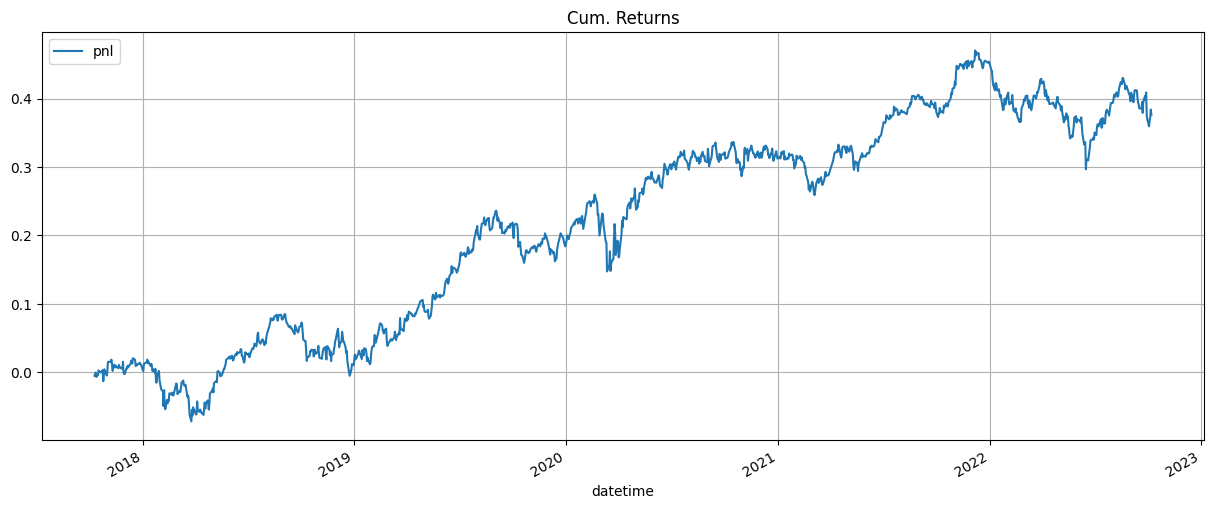

In [400]:
ax = cumret_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Cum. Returns')
plt.legend(loc=2)
plt.show()

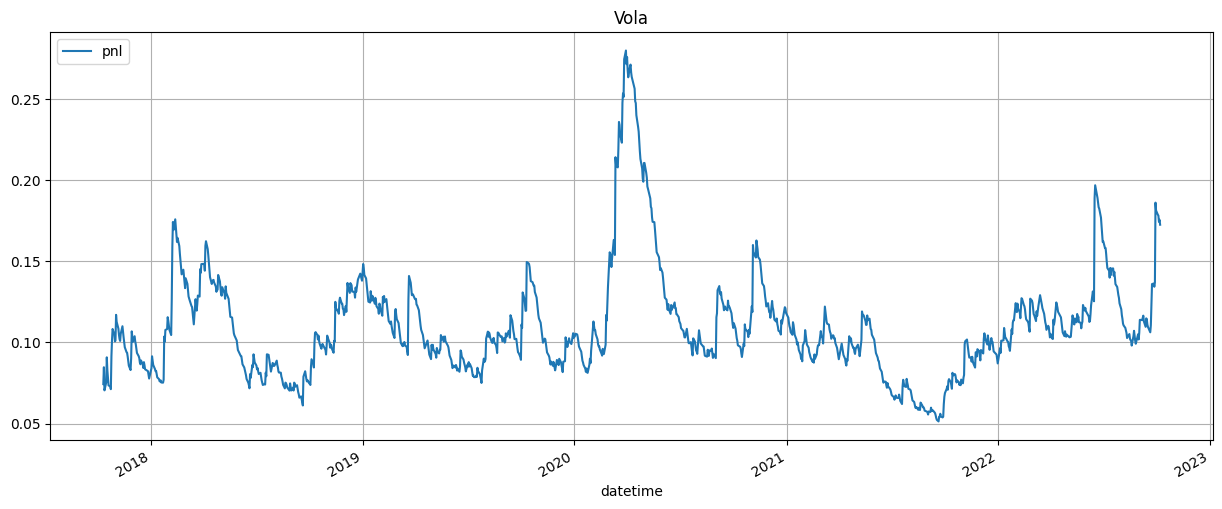

In [401]:
ax = vola_df.plot(figsize=(15, 6))
ax.grid(True)
plt.title('Vola')
plt.legend(loc=2)
plt.show()

Stat                 pnl
-------------------  ----------
Start                2017-10-09
End                  2022-10-07
Risk-free rate       0.00%

Total Return         45.68%
Daily Sharpe         0.71
Daily Sortino        1.15
CAGR                 7.82%
Max Drawdown         -15.94%
Calmar Ratio         0.49

MTD                  0.66%
3m                   1.37%
6m                   -2.69%
YTD                  -7.46%
1Y                   -0.99%
3Y (ann.)            5.45%
5Y (ann.)            7.82%
10Y (ann.)           -
Since Incep. (ann.)  7.82%

Daily Sharpe         0.71
Daily Sortino        1.15
Daily Mean (ann.)    8.18%
Daily Vol (ann.)     11.52%
Daily Skew           -0.40
Daily Kurt           2.64
Best Day             2.99%
Worst Day            -4.13%

Monthly Sharpe       0.85
Monthly Sortino      1.75
Monthly Mean (ann.)  8.09%
Monthly Vol (ann.)   9.53%
Monthly Skew         -0.05
Monthly Kurt         -0.85
Best Month           6.15%
Worst Month          -4.80%

Yearly Sharpe

<AxesSubplot: xlabel='datetime'>

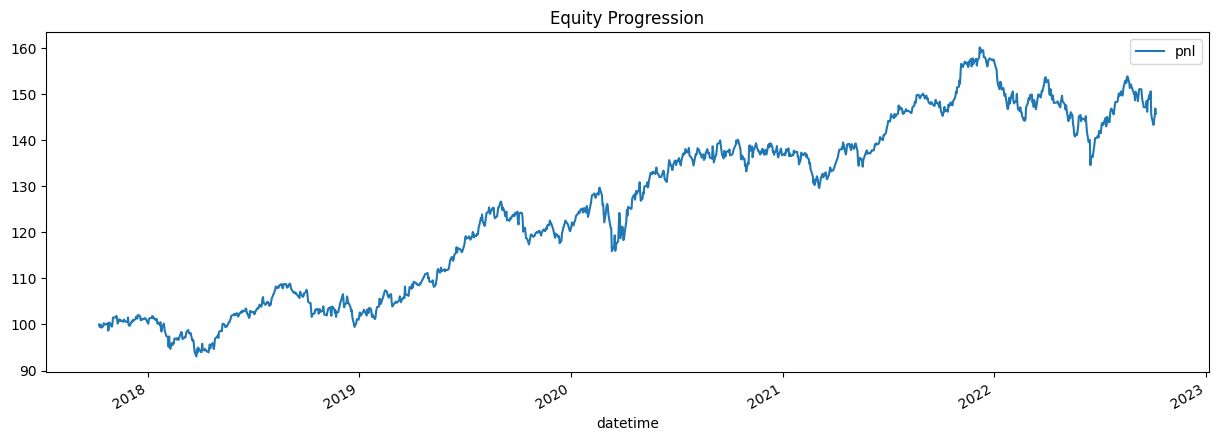

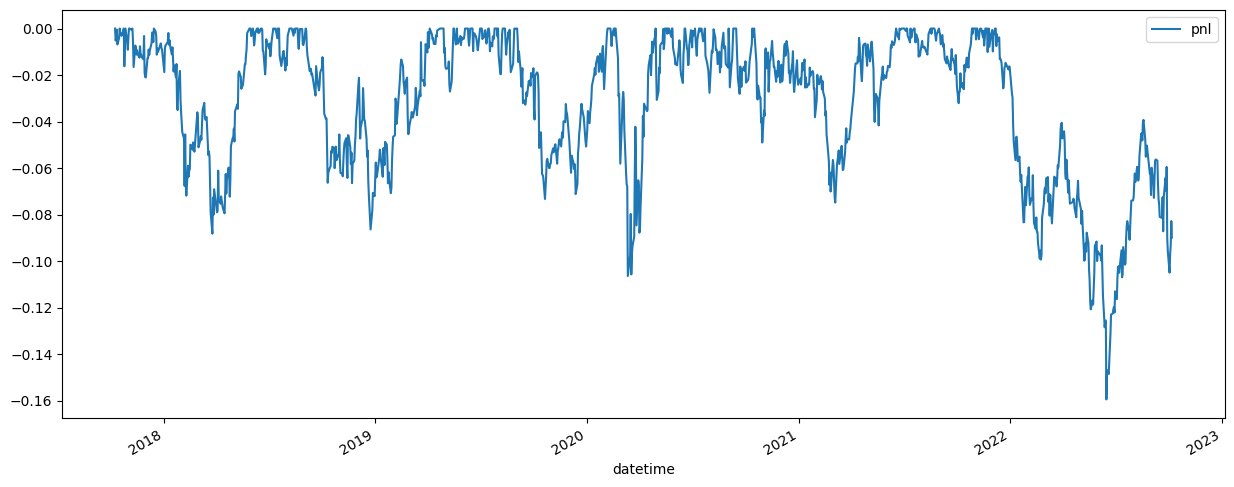

In [402]:
stats = pnl_df.calc_stats()
stats.plot()
stats.display()
stats.prices.to_drawdown_series().plot(figsize=(15,6))